In [1]:
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.stats import chi2, ksone, gamma

from radardetseval.Iface.Detection import Detection
from radardetseval.Iface.PolyLineDS import PolyLineDS
from radardetseval.configs.default_radar import DefaultRadar
from radardetseval.configs.defaut_reference import DefaultReference
from radardetseval.simulators.DetFromPolyLineSim import DetFromPolyLineSim
from radardetseval.simulators.PolyLineSim import PolyLineSim
from radardetseval.association.objective_func.nees_for_polyline import nees_value_for_vertex_ids
from radardetseval.association.nearest_point_on_line import find_nearest_point_on_segment_minimize

from radardetseval.visualization.plot_polyline import plot_polyline, plot_polyline_range_rates
from radardetseval.visualization.plot_sensor import plot_sensor
from radardetseval.visualization.plot_point import plot_point
from radardetseval.visualization.plot_detection import plot_detection_scs
from radardetseval.visualization.utilities import publish_reduced_labels
from radardetseval.utilities.ecdf import ecdf


Bad key "text.kerning_factor" on line 4 in
c:\users\lz7c3c\wkspaces\aspe0000_00_common\sandbox\radardetectionsevaluation\.venv_pe\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Simulation

In [2]:
ref_pos_std = DefaultReference.pos_std
ref_vel_std = DefaultReference.vel_std

meas_cov = np.power(np.diag([DefaultRadar.range_std, DefaultRadar.azimuth_std, DefaultRadar.range_rate_std]), 2.0)
ref_cov = np.power(np.diag([ref_pos_std, ref_pos_std, ref_vel_std, ref_vel_std]), 2)

In [3]:
gt_polyline = PolyLineDS()
gt_polyline.add_point(4, -4, 4, 0)
gt_polyline.add_point(4, 12, 4, 0)
polyline_simulator = PolyLineSim(gt_polyline)
det_simulator = DetFromPolyLineSim(gt_polyline)

In [4]:
vertex_id = 0.0
gt_point = gt_polyline.interpolate_polygon(np.array([vertex_id]), [0,1], gt_polyline.signals)
ref_polyline = polyline_simulator.sim_with_the_same_deviation(ref_cov)
detection = det_simulator.sim_single_point_from_vertex(meas_cov, vertex_id=vertex_id)

In [5]:
gt_point

,unique_id,vertex_id,x,y,vx,vy,cov_matrix
0,0.0,0.0,4.0,-4.0,4.0,0.0,"[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."


In [6]:
def plot_summary(ax, gt_polyline, ref_polyline, gt_point, detection, title_str):
    plot_sensor(ax, azimuth=np.deg2rad(75.0), max_range=15.0)
    plot_polyline(ax, gt_polyline, color='k', label = 'Ground Truth segmnet')
    plot_polyline(ax, ref_polyline, color='r', label = 'Referelnce segmnet')
    
    gt_polyline.signals = gt_polyline.discretize_single_polygon(gt_polyline.signals, 1.0)
    plot_polyline_range_rates(ax, gt_polyline, color='0.5', label = 'Ground Truth range rates')
    plot_point(ax, gt_point.x, gt_point.y, gt_point.vx, gt_point.vy, 
               color='g', markersize=10, linewidth=4, label = 'Point of intrest')
    
    plot_detection_scs(ax, detection.det_range, detection.det_range_rate, detection.det_azimuth, 
               color='b', markersize=10, linewidth=2, label = 'Measurement')    
    
    ax.set_title(title_str)
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    publish_reduced_labels(ax)
    ax.axis('equal')
    ax.grid()

(array([3.]), array([5.]))

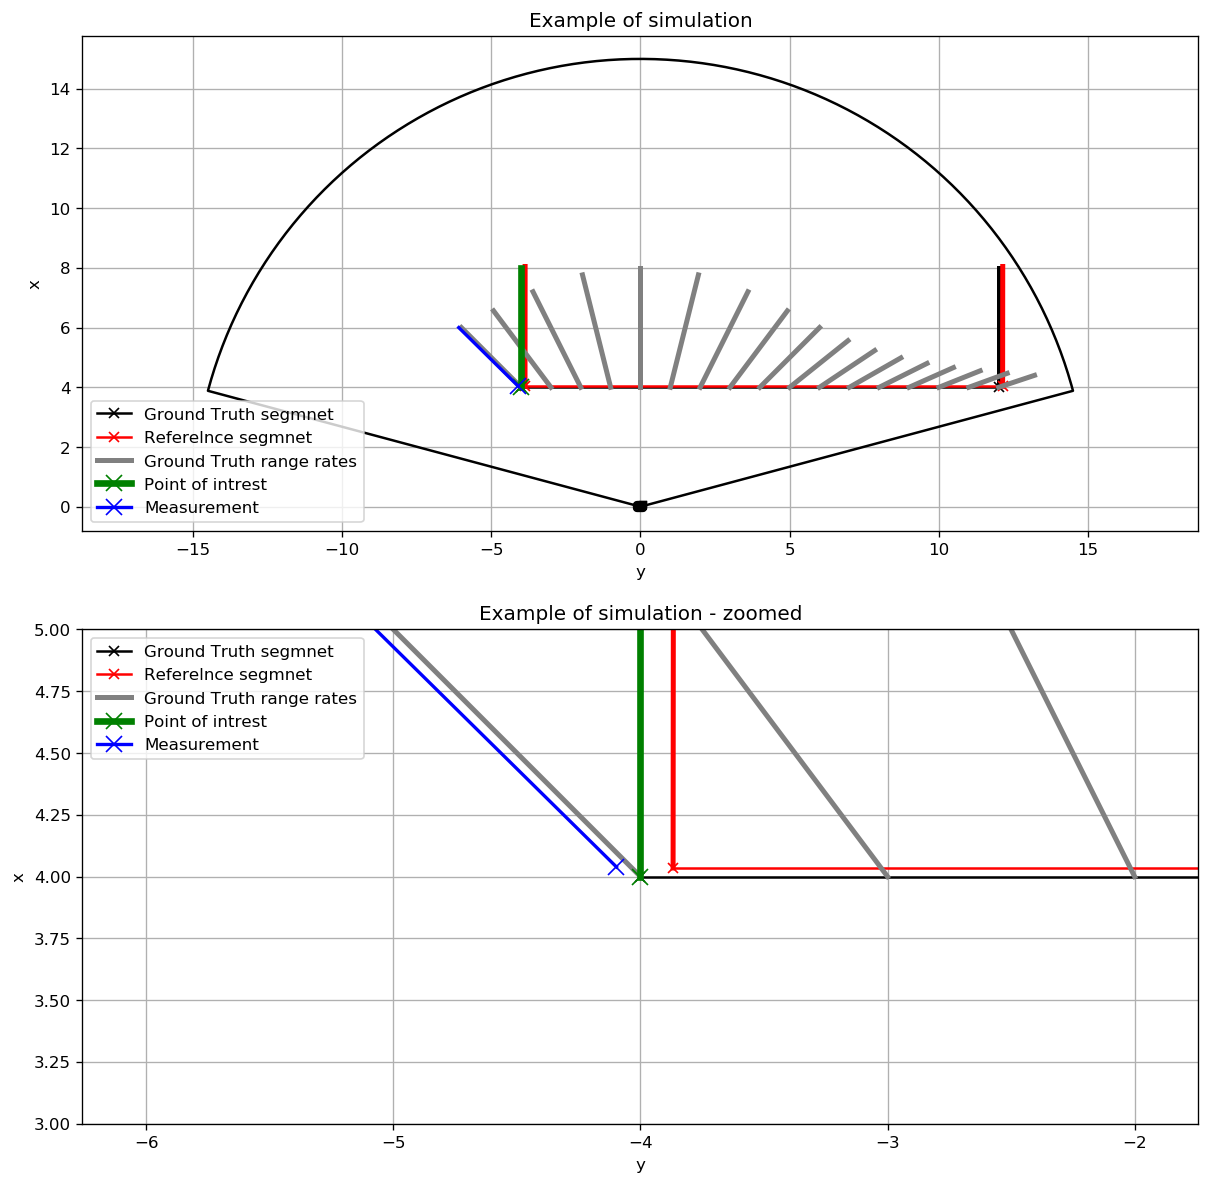

In [7]:
fig1=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')

ax1 = plt.subplot(2, 1, 1)
plot_summary(ax1, deepcopy(gt_polyline), deepcopy(ref_polyline), gt_point, detection,
             'Example of simulation')

ax2 = plt.subplot(2, 1, 2)
plot_summary(ax2, deepcopy(gt_polyline), deepcopy(ref_polyline), gt_point, detection,
             'Example of simulation - zoomed')

ax2.set_xlim([gt_point.y.values - 1,gt_point.y.values + 1])
ax2.set_ylim([gt_point.x.values - 1,gt_point.x.values + 1])

In [8]:
vertex_ids = np.linspace(0, 1, 1000)
nees = nees_value_for_vertex_ids(vertex_ids, ref_polyline, detection)

In [9]:
nearest_point = find_nearest_point_on_segment_minimize(ref_polyline, detection)

In [10]:
spread = 0.02
min_id = max([0.0, nearest_point.vertex_id - spread])
min_max = min([1.0, nearest_point.vertex_id + spread])
vertex_ids_close = np.linspace(min_id, min_max, 100)
nees_close = nees_value_for_vertex_ids(vertex_ids_close, ref_polyline, detection)

In [11]:
nearest_point

unique_id                                                     0
vertex_id                                           5.90504e-06
x                                                       4.03471
y                                                      -3.86787
vx                                                      4.01162
vy                                                   0.00402577
cov_matrix    [[0.010000000000000002, 0.0, 0.0, 0.0], [0.0, ...
range                                                   5.58921
azimuth                                               -0.764289
range_rate                                               2.8931
nees_value                                              3.18986
dtype: object

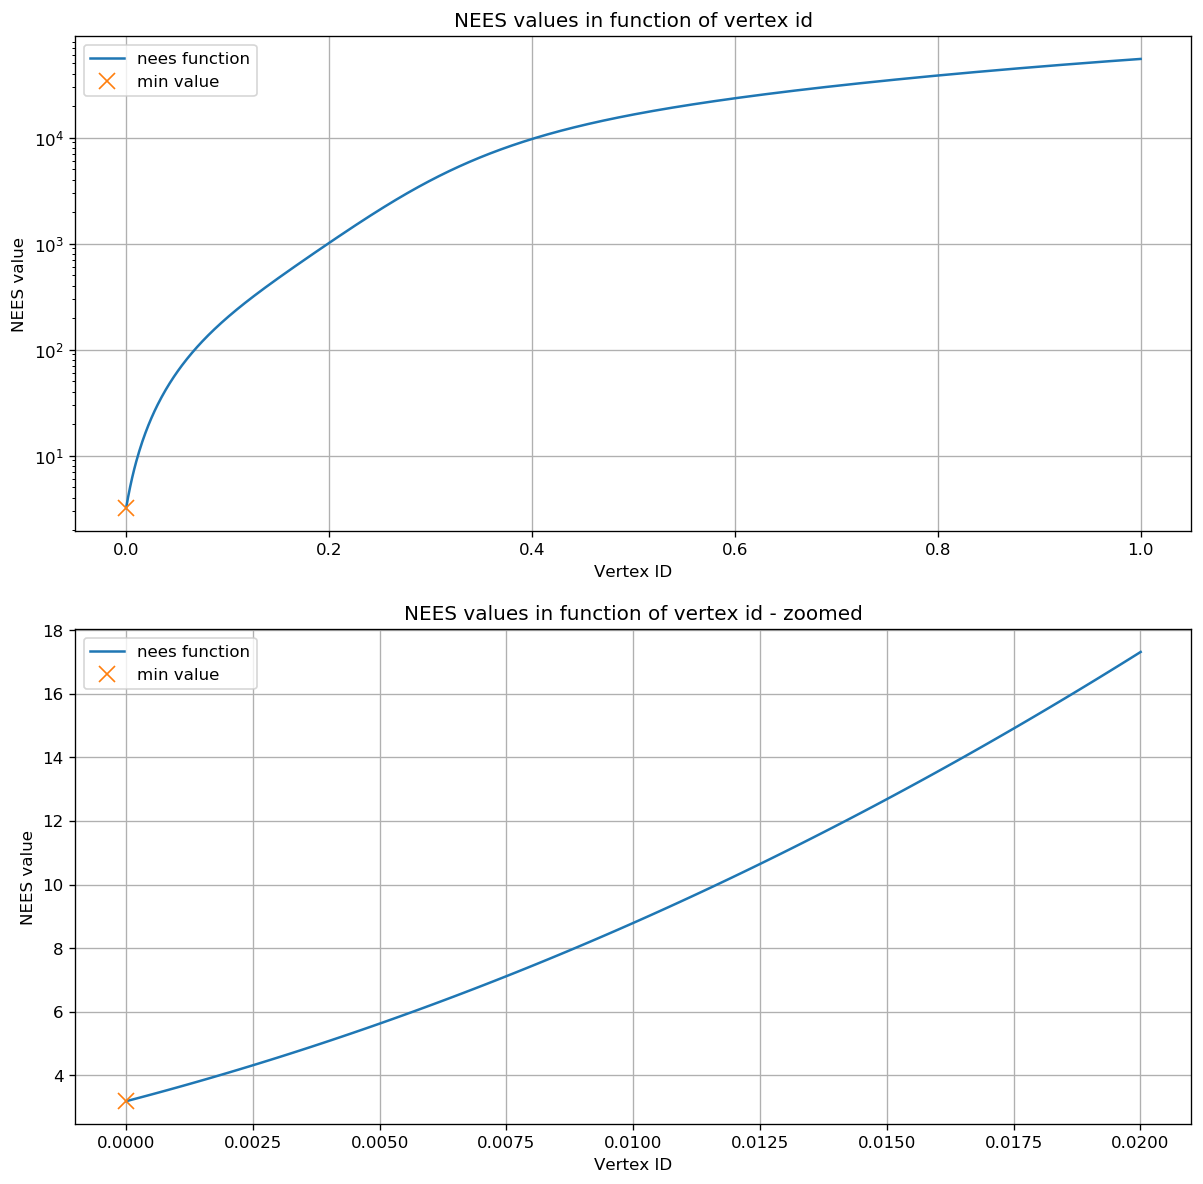

In [12]:
fig1=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')

ax1 = plt.subplot(2, 1, 1)
ax1.semilogy(vertex_ids, nees, label='nees function')
ax1.semilogy(nearest_point.vertex_id, nearest_point.nees_value, 'x', markersize=10, label='min value')
ax1.set_title('NEES values in function of vertex id')
ax1.set_xlabel('Vertex ID')
ax1.set_ylabel('NEES value')
ax1.legend()
ax1.grid()

ax2 = plt.subplot(2, 1, 2)
ax2.plot(vertex_ids_close, nees_close, label='nees function')
ax2.plot(nearest_point.vertex_id, nearest_point.nees_value, 'x', markersize=10, label='min value')
ax2.set_title('NEES values in function of vertex id - zoomed')
ax2.set_xlabel('Vertex ID')
ax2.set_ylabel('NEES value')
ax2.legend()
ax2.grid()

